## CMA-ES for CartPole Torch (assignment version)
### Christian Igel, 2024

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

You may need the following packages:

``pip install gymnasium[classic-control]``

``python -m pip install cma``

In [107]:
import gymnasium as gym  # Defines RL environments

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)  # Set size of visualization
from IPython.display import clear_output  # For inline visualization

import torch
import torch.nn as nn
import torch.nn.functional as F
# Import Env from gymnasium
from gymnasium.core import Env
import cma

# Define task
env = gym.make('CartPole-v1')
state_space_dimension = env.observation_space.shape[0]
action_space_dimension = 1  # env.action_space.n - 1

Define the policy network:

In [108]:
# Model definition
class CartPolePolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, use_bias=True):
        super(CartPolePolicyNet, self).__init__()
        # Define the hidden layer with tanh activation
        self.hidden = nn.Linear(input_size, hidden_size, bias=use_bias)
        self.tanh = nn.Tanh()
        
        # Define the output layer with linear activation
        self.output = nn.Linear(hidden_size, output_size, bias=use_bias)
        
    def forward(self, x):
        x = self.tanh(self.hidden(x))
        x = self.output(x)
        return x
    
input_size = 4  # Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity
hidden_size = 5  # Number of neurons in the hidden layer
output_size = 1  # Single output for the action spacve {0, 1} / {left, right}

# Create the policy network without bias
policy_net = CartPolePolicyNet(input_size, hidden_size, output_size, use_bias=False)


Compute number of parameters:

In [109]:
d = sum(
	param.numel() for param in policy_net.parameters()
)
print("Number of parameters:", d)

Number of parameters: 25


Helper function for visualization:

In [110]:
def visualize_policy(policy_net):
    env_render = gym.make('CartPole-v1', render_mode='rgb_array')
    state = env_render.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
    steps = 0
    while True:
        out = policy_net(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
        steps+=1
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        clear_output(wait=True)
        plt.imshow(env_render.render())
        plt.show()
        print("step:", steps)
        if(terminated or truncated): 
            break
    env_render.close()
    return

In [111]:
# visualize_policy(policy_net)

Now we define the objective/reward function. 
When the task is solved the functions returns -1000.
One successful trial is sufficient.

In [112]:
def fitness_cart_pole(x, nn, env: Env):
    '''
    Returns negative accumulated reward for single pole, fully environment.

    Parameters:
        x: Parameter vector encoding the weights.
        nn: Parameterized model.
        env: Environment ('CartPole-v?').
    '''
    torch.nn.utils.vector_to_parameters(torch.Tensor(x), nn.parameters())  # Set the policy parameters
    
    state = env.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
          
    R = 0  # Accumulated reward
    while True:
        out = nn(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env.step(a)  # Simulate pole
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        R += reward  # Accumulate 
        if truncated:
            return -1000  # Episode ended, final goal reached, we consider minimization
        if terminated:
            return -R  # Episode ended, we consider minimization
    return -R  # Never reached  

Do the learning:

In [113]:
# Generate initial search point and initial hidden RNN states
initial_weights = np.random.normal(0, 0.01, d)  # Random parameters for initial policy, d denotes the number of weights
initial_sigma = .01 # Initial global step-size sigma

# Do the optimization
res = cma.fmin(fitness_cart_pole,  # Objective function
               initial_weights,  # Initial search point
               initial_sigma,  # Initial global step-size sigma
               args=([policy_net, env]),  # Arguments passed to the fitness function
               options={'ftarget': -999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
# env.close()

# Set the policy parameters to the final solution
torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), policy_net.parameters())  

print("best solution found after", res[2], "evaluations")

(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 25 (seed=629756, Mon Mar  4 13:57:42 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 -2.270000000000000e+02 1.0e+00 9.20e-03  9e-03  9e-03 0:00.1


    2     26 -1.000000000000000e+03 1.1e+00 8.77e-03  9e-03  9e-03 0:00.3
termination on ftarget=-999.9 (Mon Mar  4 13:57:42 2024)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 26/19 evaluations
incumbent solution: [-0.00171516 -0.00350785  0.01578565  0.00663034  0.0095748  -0.00096033
  0.01533892  0.00446399 ...]
std deviations: [0.00884095 0.00868168 0.00877169 0.00876525 0.00875781 0.00874204
 0.00876289 0.00872622 ...]
best solution found after 19 evaluations


Render solution:

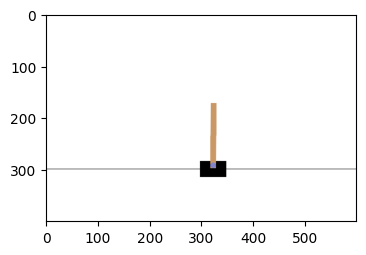

step: 500


In [114]:
visualize_policy(policy_net)

Learn more about CMA-ES optimization:

In [115]:
# Visualize the optimization 
# cma.plot();  

In [116]:
# Learn even more on CMA-ES
# cma.CMAOptions() 

In [117]:
def test_balance(policy_net, env, steps_to_balance=500):
   
    for t in range(steps_to_balance):  # Test for 500 steps
        state = env.reset(options={'low': -0.05, 'high': 0.05}, seed=<some random seed>) # Forget about previous episode
        state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
        
        action_scores = policy_net(state_tensor)
        
        action = (action_scores > 0).long().item()
        state, _, done, _, _ = env.step(action)
        if done:
            return t+1
        
    return steps_to_balance  # Successfully balanced for all 500 steps


In [118]:
# Perform the experiment in a single cell

# Parameters
num_runs = 10
steps_to_balance = 500
results = {'with_bias': {'balanced_for': [], 'trained_for': []}, 'without_bias':  {'balanced_for': [], 'trained_for': []}}

for use_bias in [False, True]:
    for run in range(num_runs):
        policy_net = CartPolePolicyNet(input_size, hidden_size, output_size, use_bias=use_bias)
        
        num_params = sum(p.numel() for p in policy_net.parameters())
        
        initial_weights = np.random.normal(0, 0.01, num_params)
        initial_sigma = .01 
        # Do the optimization
        res = cma.fmin(fitness_cart_pole,  # Objective function
                    initial_weights,  # Initial search point
                    initial_sigma,  # Initial global step-size sigma
                    args=([policy_net, env]),  # Arguments passed to the fitness function
                    options={'ftarget': -999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
        env.close()

        print("best solution found after", res[2], "evaluations")

        # balance_steps = visualize_policy(policy_net)
        # visualize_policy(policy_net)
        balance_steps = test_balance(policy_net, env, steps_to_balance)
        results['with_bias' if use_bias else 'without_bias']['balanced_for'].append(balance_steps)
        results['with_bias' if use_bias else 'without_bias']['trained_for'].append(res[2])
        print("Run:", run, "Use bias:", use_bias, "Balance steps:", balance_steps)

(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 25 (seed=641693, Mon Mar  4 13:58:55 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 -1.660000000000000e+02 1.0e+00 9.40e-03  9e-03  9e-03 0:00.1
    2     26 -1.000000000000000e+03 1.1e+00 9.18e-03  9e-03  9e-03 0:00.3
termination on ftarget=-999.9 (Mon Mar  4 13:58:56 2024)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 26/22 evaluations
incumbent solution: [ 0.00089784 -0.00410512  0.00615949 -0.00175115  0.00636829 -0.00997858
  0.00264937  0.00099265 ...]
std deviations: [0.00906426 0.00919558 0.00921546 0.00918284 0.0091359  0.00914951
 0.00908388 0.00909984 ...]
best solution found after 22 evaluations
Run: 0 Use bias: False Balance steps: 500
(6_w,13)-aCMA-ES (mu_w=4.0,w_1=38%) in dimension 25 (seed=615027, Mon Mar  4 13:58:56 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 -1.000000000000000e+03 1.0e+00 9.24e-03  9e-03  9e-03 0:00.1

In [119]:
# Calculate and print average performance
for k, v in results.items():
    average_performance = {k: np.mean(v) for k, v in v.items()}
    for key, val in average_performance.items():
        print(f"{k}, {key}: {val}")

with_bias, balanced_for: 500.0
with_bias, trained_for: 1393.7
without_bias, balanced_for: 500.0
without_bias, trained_for: 33.1
